In [1]:
import mlflow
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# import seaborn as sns
import re
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
def legend():
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    # by_label = dict(zip(labels+labels2, lines+lines2))
    # plt.legend(by_label.values(), by_label.keys())
    plt.legend(lines + lines2, labels + labels2)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def DAG_to_pyvis(dag):
    # nt = Network('500px', '500px', directed=True, notebook=True, cdn_resources='remote')
    nt = Network(directed=True)
    
    for node in dag.nodes:
        size = dag.nodes[node]['size']
        attrs = {'x': None, 'y': None, 'physics': True, 
                 'label': [],
                 'color': size_to_color(size), 'mass': 4, 'shape':'box'}
        if node=='start': attrs.update({'x': 1.0, 'y': 0.0, 'physics': False})
        elif node == 'end': attrs.update({'x': 15.0, 'y': 0.0, 'physics': False})
        nt.add_node(node, **attrs)
    for edge in dag.edges:
        prev_node, next_node = edge
        # nt.add_node(prev_node, label=prev_node, title=str(dag.nodes[prev_node]['size']))
        # nt.add_node(next_node, label=next_node, title=str(dag.nodes[next_node]['size']))
        nt.add_edge(prev_node, next_node, title=str(dag.edges[edge]['link']))

    # print(nt.get_node('start'))
    # nt.toggle_physics(False)
    return nt

def size_to_color(size):
    cmap=mpl.cm.Reds
    norm=mpl.colors.Normalize(vmin=0, vmax=784)
    rgba = cmap(norm(size))
    return mpl.colors.rgb2hex(rgba)

In [4]:
def history_transform(history):
    x, y = [], []
    x_updated, y_updated = [], []
    for i, snapshot in history.items():
        step = int(i)
        for k, v in snapshot.items():
            if v == 2:
                x.append(step)
                y.append(k)
            if v == 1: 
                x_updated.append(step)
                y_updated.append(k)
    return x, y, x_updated, y_updated

In [5]:
%cd "/home/sdouka/Documents/tiny.worktrees/GroMo"
os.getcwd()

/home/sdouka/Documents/tiny.worktrees/GroMo


/home/sdouka/miniconda3/envs/tiny/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/home/sdouka/Documents/tiny.worktrees/GroMo'

In [6]:
client = mlflow.client.MlflowClient()
# mlflow.set_tracking_uri(uri="http://127.0.0.1:27027")

In [7]:
def get_runs(exp_name):
    experiment = client.get_experiment_by_name(exp_name)
    runs = client.search_runs([experiment.experiment_id])
    print("Number of runs", len(runs))
    runIds = [run.info.run_id for run in runs]
    return runIds

In [8]:
runIds = get_runs("MNIST")
runIds

Number of runs 8


['dd270e90b9654570b324f8cf710a9db3',
 'e0e360daaa8d470ea02b33b54fedb462',
 'c064dacb053749819f8b9f4f0933dcce',
 '962476f74c0b4993bbf4e9a2003b15b4',
 '025effeb0eef416faf762f86e9f439f5',
 '7ffe2bb615dc40958b45826cf2105cba',
 '20ddf969d51d48e7801409655f1783d0',
 '9733a6f47cea4eacb58db4a04fa71d68']

In [9]:
def get_logs(runIDs):
    if not isinstance(runIDs, list): runIDs = [runIDs]
    print(runIDs)

    run_info = {}
    run_info_t = {}
    for runID in runIDs:
        # run_info["steps"].append({item.step: item.step for item in client.get_metric_history})
        for key in client.get_run(runID).data.metrics.keys():
            if key not in run_info:
                run_info[key] = []
                run_info_t[key] = []
            
            run_info[key].append({item.step: item.value for item in client.get_metric_history(runID, key)})
            run_info_t[key].append({item.timestamp: item.value for item in client.get_metric_history(runID, key)})
        
        try:
            # mlflow.artifacts.load_dict("mlflow-artifacts:/235085688558347327/e95c2ea3c22f44cb950829023dffc42e/artifacts/gh.json")
            artifact_uri = mlflow.artifacts.download_artifacts(run_id=runID, artifact_path="gh.json")
            with open(artifact_uri, 'r') as f:
                data = json.load(f)
            print(f"Got growth history for {artifact_uri}")
            if 'growth' not in run_info: 
                run_info['growth'] = []
            run_info['growth'].append(data)
        except mlflow.MlflowException as err:
            print(f"[Run {runID}] {err}")
        except Exception as err:
            pass
    return run_info, run_info_t

In [27]:
run_info, run_info_t = get_logs(runIds[0])
list(run_info.keys())

['dd270e90b9654570b324f8cf710a9db3']


['growth train loss',
 'dev accuracy',
 'growth dev loss',
 'dev loss',
 'growth val loss',
 'growth val accuracy',
 'test loss',
 'test accuracy',
 'growth dev accuracy',
 'val accuracy',
 'growth train accuracy',
 'val loss',
 'Intermediate training/dev accuracy',
 'Intermediate training/dev loss',
 'Intermediate training/val accuracy',
 'Intermediate training/val loss',
 'complexity/nb of parameters',
 'complexity/activations',
 'complexity/flops',
 'complexity/in-degree/node 8',
 'complexity/in-degree/node 10',
 'complexity/in-degree/node 13',
 'complexity/in-degree/node 5',
 'complexity/in-degree/node 7',
 'complexity/in-degree/node 1',
 'complexity/in-degree/node 12',
 'complexity/in-degree/node 2',
 'complexity/in-degree/node start',
 'complexity/in-degree/node 4',
 'complexity/in-degree/node 11',
 'complexity/in-degree/node 3',
 'complexity/in-degree/node 9',
 'complexity/in-degree/node end',
 'complexity/in-degree/node 6',
 'complexity/nb of parameters at/layer 5_12',
 'comple

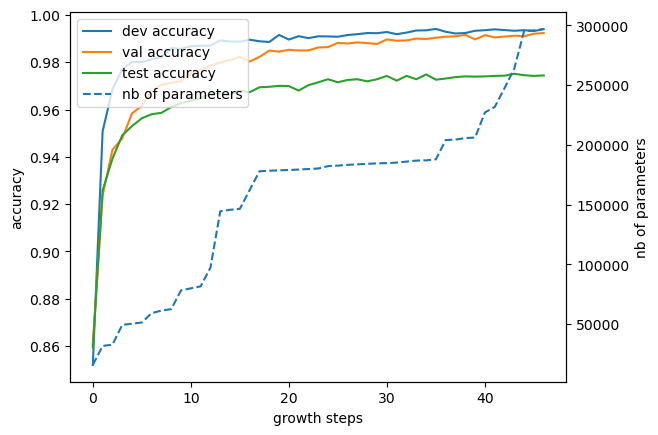

In [28]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for i in range(len(run_info['complexity/nb of parameters'])):
    ax1.plot(run_info['dev accuracy'][i].values(), label='dev accuracy')
    ax1.plot(run_info['val accuracy'][i].values(), label='val accuracy')
    ax1.plot(run_info['test accuracy'][i].values(), label='test accuracy')
    ax2.plot(run_info['complexity/nb of parameters'][i].values(), '--', label='nb of parameters')
ax1.set_ylabel('accuracy')
ax2.set_ylabel('nb of parameters')
ax1.set_xlabel('growth steps')
plt.xlabel('steps')
legend()
plt.show()

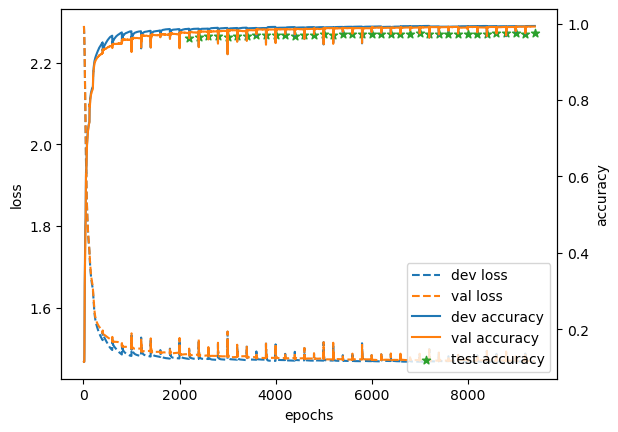

In [34]:
crop = 10
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for i in range(len(run_info['complexity/nb of parameters'])):
    ax1.plot(list(run_info['Intermediate training/dev loss'][i].keys())[crop:], list(run_info['Intermediate training/dev loss'][i].values())[crop:], "--", label="dev loss")
    ax1.plot(list(run_info['Intermediate training/val loss'][i].keys())[crop:], list(run_info['Intermediate training/val loss'][i].values())[crop:], "--", label="val loss")
    ax2.plot(list(run_info['Intermediate training/dev accuracy'][i].keys())[crop:], list(run_info['Intermediate training/dev accuracy'][i].values())[crop:], label="dev accuracy")
    ax2.plot(list(run_info['Intermediate training/val accuracy'][i].keys())[crop:], list(run_info['Intermediate training/val accuracy'][i].values())[crop:], label="val accuracy")
    # ax1.scatter(run_info['test loss'][i].keys(), run_info['test loss'][i].values(), marker="*", color=colors[2], label="test loss")
    ax2.scatter(list(run_info['test accuracy'][i].keys())[crop:], list(run_info['test accuracy'][i].values())[crop:], marker="*", color=colors[2], label="test accuracy")
    # ax2.scatter(run_info['growth val accuracy'][i].keys(), run_info['growth val accuracy'][i].values(), marker="*", color=colors[3], label="test accuracy")
    # ax2.scatter(run_info['val accuracy'][i].keys(), run_info['val accuracy'][i].values(), marker="*", color=colors[4], label="test accuracy")
ax1.set_ylabel("loss")
ax2.set_ylabel("accuracy")
ax1.set_xlabel("epochs")
legend()
plt.show()

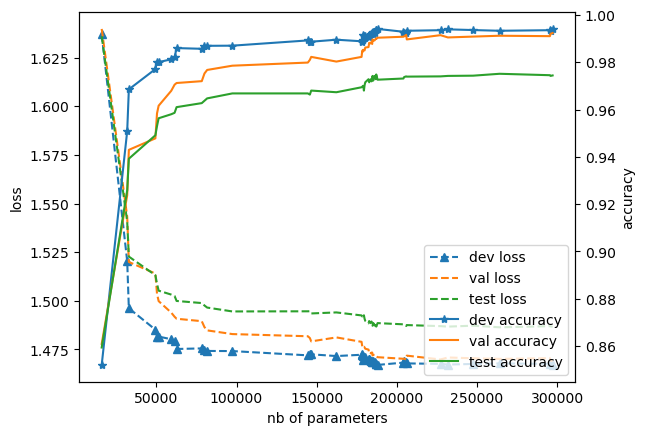

In [30]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for i in range(len(run_info['complexity/nb of parameters'])):
    ax1.plot(run_info['complexity/nb of parameters'][i].values(), run_info['dev loss'][i].values(), '--^', label='dev loss')
    ax1.plot(run_info['complexity/nb of parameters'][i].values(), run_info['val loss'][i].values(), '--', label='val loss')
    ax1.plot(run_info['complexity/nb of parameters'][i].values(), run_info['test loss'][i].values(), '--', label='test loss')
    ax2.plot(run_info['complexity/nb of parameters'][i].values(), run_info['dev accuracy'][i].values(), '-*', label='dev accuracy')
    ax2.plot(run_info['complexity/nb of parameters'][i].values(), run_info['val accuracy'][i].values(), label='val accuracy')
    ax2.plot(run_info['complexity/nb of parameters'][i].values(), run_info['test accuracy'][i].values(), label='test accuracy')
ax1.set_ylabel('loss')
ax2.set_ylabel('accuracy')
ax1.set_xlabel('nb of parameters')
legend()
plt.show()

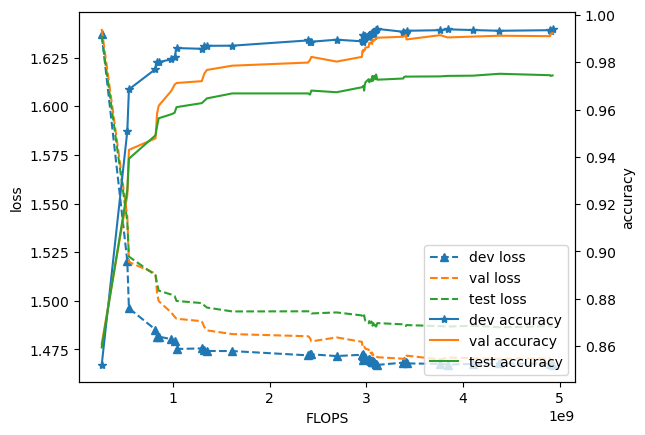

In [31]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for i in range(len(run_info['complexity/nb of parameters'])):
    ax1.plot(run_info['complexity/flops'][i].values(), run_info['dev loss'][i].values(), '--^', label='dev loss')
    ax1.plot(run_info['complexity/flops'][i].values(), run_info['val loss'][i].values(), '--', label='val loss')
    ax1.plot(run_info['complexity/flops'][i].values(), run_info['test loss'][i].values(), '--', label='test loss')
    ax2.plot(run_info['complexity/flops'][i].values(), run_info['dev accuracy'][i].values(), '-*', label='dev accuracy')
    ax2.plot(run_info['complexity/flops'][i].values(), run_info['val accuracy'][i].values(), label='val accuracy')
    ax2.plot(run_info['complexity/flops'][i].values(), run_info['test accuracy'][i].values(), label='test accuracy')
ax1.set_ylabel('loss')
ax2.set_ylabel('accuracy')
ax1.set_xlabel('FLOPS')
legend()
plt.show()

In [32]:
print(run_info_t['system/gpu_0_memory_usage_megabytes'][0])
print(run_info_t['dev loss'][0])

{1727714800980: 560.9, 1727714810997: 1039.1, 1727714821014: 1196.4, 1727714831034: 1353.6, 1727714841058: 1353.6, 1727714851080: 1355.7, 1727714861116: 1517.2, 1727714871134: 1517.2, 1727714881158: 1569.7, 1727714891177: 1569.7, 1727714901195: 1767.0, 1727714911222: 1569.7, 1727714921251: 1569.7, 1727714931483: 1626.3, 1727714941518: 1785.7, 1727714951550: 1785.7, 1727714961580: 2108.6, 1727714971604: 2108.6, 1727714981644: 2108.6, 1727714991677: 2110.7, 1727715001709: 2110.7, 1727715011737: 2110.7, 1727715021769: 2435.8, 1727715031970: 2544.8, 1727715042003: 2546.9, 1727715052039: 2546.9, 1727715062072: 2651.8, 1727715072104: 3140.4, 1727715082144: 3192.8, 1727715092183: 3192.8, 1727715102376: 3192.8, 1727715112411: 3192.8, 1727715122453: 3192.8, 1727715132482: 3197.0, 1727715142525: 3197.0, 1727715152556: 3197.0, 1727715162591: 3197.0, 1727715172641: 3205.4, 1727715182671: 3407.0, 1727715192714: 3209.6, 1727715202752: 3209.6, 1727715212787: 3209.6, 1727715222833: 3209.6, 17277152328

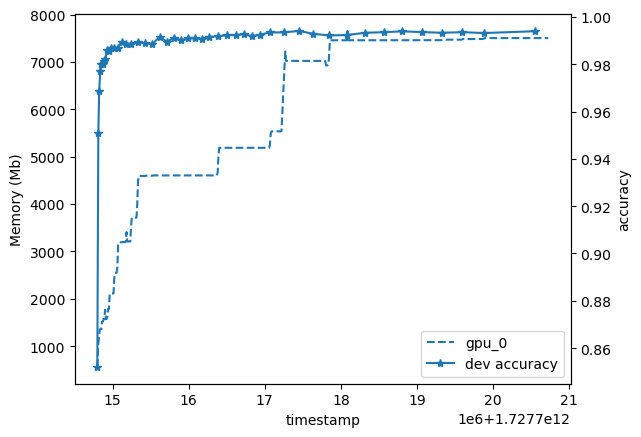

In [33]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for i in range(len(run_info_t['complexity/nb of parameters'])):
    ax1.plot(run_info_t['system/gpu_0_memory_usage_megabytes'][i].keys(), run_info_t['system/gpu_0_memory_usage_megabytes'][i].values(), '--', label='gpu_0')
    # plt.plot(run_info_t['system/system_memory_usage_megabytes'][i].values(), '--', label='system')
    ax2.plot(run_info_t['dev accuracy'][i].keys(), run_info_t['dev accuracy'][i].values(), '-*', label='dev accuracy')
ax1.set_ylabel('Memory (Mb)')
ax2.set_ylabel('accuracy')
ax1.set_xlabel('timestamp')
legend()
plt.show()